# Proyek Macihne Learning: Chest Image
- **Nama:** Kurnia Raihan Ardian
- **Email:** raihanardila22@gmail.com
- **ID Dicoding:** raihanardila

Persiapan Library

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import random
from PIL import Image
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


Load Dataset

In [39]:
# Path dataset yang benar
dataset_path = "/Users/s2idev/.cache/kagglehub/datasets/sayedgamal99/smoke-fire-detection-yolo/versions/1/data"
train_dir = os.path.join(dataset_path, "train/images")
val_dir = os.path.join(dataset_path, "val/images")
test_dir = os.path.join(dataset_path, "test/images")

print("🔍 Train folder exists:", os.path.exists(train_dir), "-> Isi:", len(os.listdir(train_dir)))
print("🔍 Validation folder exists:", os.path.exists(val_dir), "-> Isi:", len(os.listdir(val_dir)))
print("🔍 Test folder exists:", os.path.exists(test_dir), "-> Isi:", len(os.listdir(test_dir)))

# Pastikan folder test ada
os.makedirs(test_dir, exist_ok=True)

# Ambil semua file gambar langsung dari train/images/
image_files = os.listdir(train_dir)
invalid_files = [f for f in image_files if not f.endswith(('.jpg', '.png'))]
if invalid_files:
    print("🚨 File dengan format tidak didukung ditemukan:", invalid_files)
    raise ValueError("🚨 Dataset memiliki file dengan format tidak didukung. Hapus atau konversi formatnya!")

# Tentukan 10% data untuk test set
test_size = int(0.1 * len(image_files))
test_files = random.sample(image_files, test_size)

# Pindahkan file ke test/images/
for file in test_files:
    shutil.move(os.path.join(train_dir, file), os.path.join(test_dir, file))

image_files = os.listdir(train_dir)
invalid_files = [f for f in image_files if not f.endswith(('.jpg', '.png'))]
if invalid_files:
    print("🚨 File dengan format tidak didukung ditemukan:", invalid_files)
    raise ValueError("🚨 Dataset memiliki file dengan format tidak didukung. Hapus atau konversi formatnya!")


print("✅ Data telah dipisahkan menjadi Train, Validation, dan Test Set.")

🔍 Train folder exists: True -> Isi: 5474
🔍 Validation folder exists: True -> Isi: 3099
🔍 Test folder exists: True -> Isi: 12955
✅ Data telah dipisahkan menjadi Train, Validation, dan Test Set.


Data Augmentation & Preprocessing

In [53]:
# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    os.path.dirname(train_dir),  # Ambil dari parent folder train/images
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"  # Gunakan "categorical" jika lebih dari 2 kelas
)

val_generator = val_datagen.flow_from_directory(
    os.path.dirname(val_dir),
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_datagen.flow_from_directory(
    os.path.dirname(test_dir),
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)


x_batch, y_batch = next(train_generator)
print("✅ Dataset berhasil dimuat:", x_batch.shape, y_batch.shape)

num_classes = len(train_generator.class_indices)
print("📂 Kelas dalam dataset:", train_generator.class_indices)


if len(train_generator) == 0:
    raise ValueError("🚨 train_generator tidak memiliki data! Periksa path dan format file.")
if len(val_generator) == 0:
    raise ValueError("🚨 val_generator tidak memiliki data! Periksa path dan format file.")
if len(test_generator) == 0:
    raise ValueError("🚨 test_generator tidak memiliki data! Periksa path dan format file.")



Found 4927 images belonging to 2 classes.
Found 3099 images belonging to 2 classes.
Found 13501 images belonging to 2 classes.
✅ Dataset berhasil dimuat: (32, 150, 150, 3) (32,)
📂 Kelas dalam dataset: {'images': 0, 'labels': 1}


Membangun Model CNN

In [54]:
# Membangun Model CNN
# Membangun Model CNN yang lebih kompleks
model = Sequential([
    Input(shape=(150,150,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Gunakan 'softmax' jika multiclass
])

Compile Model

In [55]:
# Compile Model
loss_function = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.0003), loss=loss_function, metrics=['accuracy'])


learning rate

In [56]:
def lr_schedule(epoch):
    initial_lr = 0.0005
    drop = 0.5
    epochs_drop = 5
    return initial_lr * (drop ** (epoch // epochs_drop))

lr_scheduler = LearningRateScheduler(lr_schedule)


Callback: EarlyStopping & ReduceLROnPlateau

In [57]:
# Callback: EarlyStopping & ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)



Training Model

In [45]:
# Training Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9868 - loss: 0.0232 - val_accuracy: 1.0000 - val_loss: 1.0808e-18 - learning_rate: 3.0000e-04
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 1.0000 - loss: 1.3654e-10 - val_accuracy: 1.0000 - val_loss: 6.2864e-23 - learning_rate: 3.0000e-04
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 1.0000 - loss: 6.5639e-12 - val_accuracy: 1.0000 - val_loss: 2.2645e-10 - learning_rate: 3.0000e-04
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 1.0000 - loss: 8.9395e-08 - val_accuracy: 1.0000 - val_loss: 2.9002e-09 - learning_rate: 3.0000e-04
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3123s 20s/step - accuracy: 1.0000 - loss: 3.1328e-09 - val_accuracy: 1.0000 - val_loss: 1.1020e-10 - learning_rate: 6.0000e-05
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3449s 23s/step - accuracy: 1.0000 - loss: 3.5669e-07 - val_accuracy: 1.0000 - val_loss: 3.1083e-11 - learning_rate: 6.0000e-05
Epoch 7/30

Evaluasi Model

In [58]:
# Evaluasi Model
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Akurasi Training: {train_acc*100:.2f}%")
print(f"✅ Akurasi Validation: {val_acc*100:.2f}%")
print(f"✅ Akurasi Model pada Test Set: {test_acc * 100:.2f}%")

/Users/s2idev/PycharmProjects/xraymodel/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 158s 373ms/step - accuracy: 0.9971 - loss: 0.6450
✅ Akurasi Training: 100.00%
✅ Akurasi Validation: 100.00%
✅ Akurasi Model pada Test Set: 99.75%


Plot Akurasi dan Loss

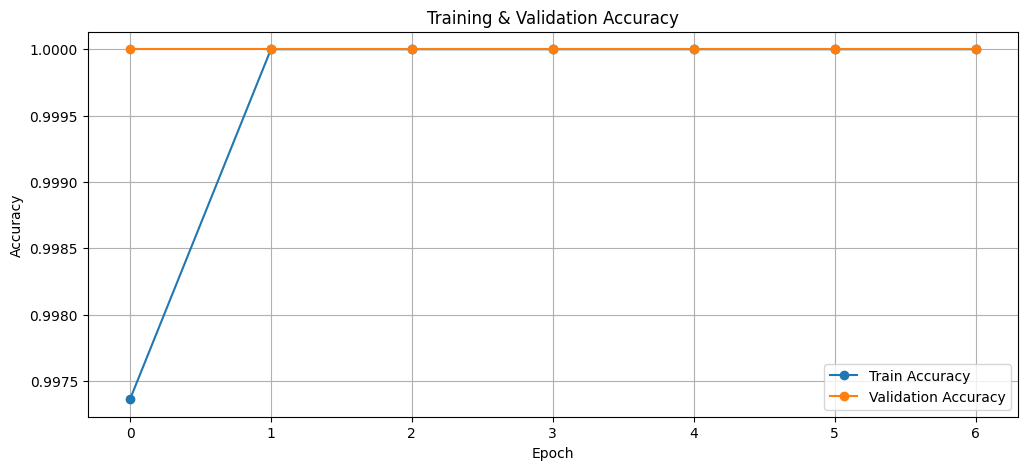

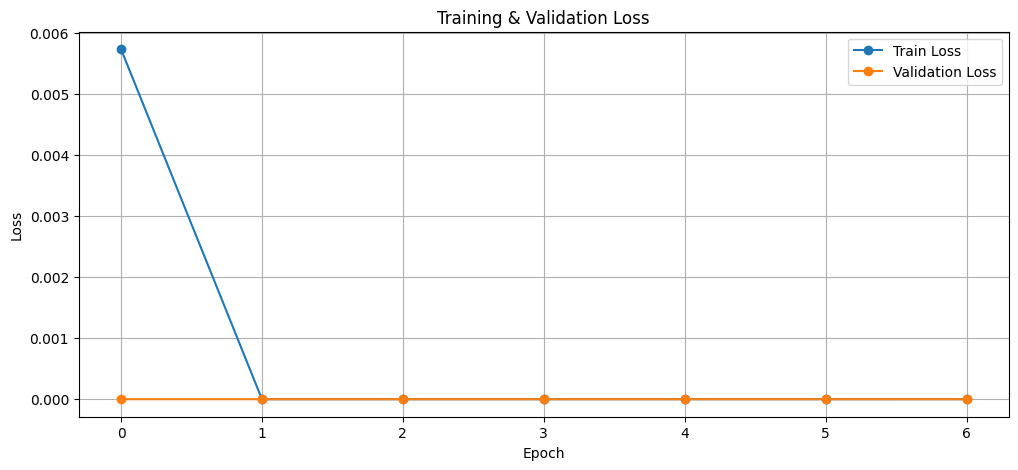

In [59]:
# Plot Akurasi dan Loss

# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Menyimpan Model dalam 3 Format

In [60]:
# Menyimpan Model dalam 3 Format
model.save("saved_model.keras")

model.save("saved_model.h5")

model.export("saved_model/")  # Format TensorFlow SavedModel


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_85')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  6397480272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397495600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397513792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397513968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397496480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397496656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397516256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397516080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397530880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397531408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6397530352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

Konversi ke TF-Lite

In [61]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")
tflite_model = converter.convert()
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

    # Pastikan folder `assets/` ada
assets_dir = "saved_model/assets"
os.makedirs(assets_dir, exist_ok=True)

# Simpan label ke dalam `assets/`
labels = ["Normal", "Pneumonia", "Tuberculosis"]
with open(os.path.join(assets_dir, "labels.txt"), "w") as f:
    f.write("\n".join(labels))

print("✅ Label berhasil ditambahkan ke saved_model/assets/")

W0000 00:00:1740792256.778695  692040 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1740792256.779771  692040 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-03-01 08:24:16.783648: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/
2025-03-01 08:24:16.785965: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-03-01 08:24:16.785987: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model/
2025-03-01 08:24:16.826233: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-03-01 08:24:16.989733: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model/
2025-03-01 08:24:17.014804: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 232034 microseconds.


✅ Label berhasil ditambahkan ke saved_model/assets/


Simpan label TF-Lite

In [63]:
# Simpan label TF-Lite
labels = ["Normal", "Pneumonia", "Tuberculosis"]
with open("tflite/label.txt", "w") as f:
    f.write("\n".join(labels))


Konversi Model ke TFJS

In [64]:
# Konversi Model ke TFJS
!pip install tensorflowjs  # Pastikan TensorFlow.js sudah terinstal
os.makedirs("tfjs_model", exist_ok=True)
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model